# __Prueba 2: Analizado los crímenes en la Ciudad de Nueva York__

## Contexto
En esta ocasión trabajaremos con datos públicos del departamento de policía de New York.
El dataset es llamado `stop_and_frisk_data` y contiene información sobre interrogaciones
y detenciones realizadas por el departamento de policía de NY en la vía pública. El
diccionario de atributos se encuentra en el archivo `2009 SQF File Spec.xls`.

Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como
conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer
notar que los datos que estamos utilizando son un muestreo del de la cantidad de registros
reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de
entrenamiento y procesamiento que requiere el volumen de datos reales.



## Objetivos
Para alcanzar el objetivo general, su trabajo se puede desagregar en los siguientes puntos:
1. Debe analizar de forma exploratoria los atributos. Reporte la cantidad de datos
perdidos y presente su esquema de recodificación. Tenga presente que lo que
observe en el análisis exploratorio debe guiar su proceso de ingeniería de atributos,
por lo que se le recomienda que piense en aspectos de las variables involucradas
que puedan afectar el proceso mencionado.
2. Reporte la probabilidad que un individuo sea arrestado en uno de los cinco barrios,
condicional al género y a la raza. Concluya, ¿qué implicancias éticas tienen algunas
conclusiones de lo que observa?.
3. Entregue un modelo predictivo que prediga efectivamente si un determinado
procedimiento concluirá en un arresto o no. Para ello, guíate por los siguientes
lineamientos:
   - Entrene por lo menos 3 modelos que sean capaces de predecir si se
producirá un arresto o no. Una vez que encuentre un modelo satisfactorio,
reporte al menos dos métricas de desempeño.
   - Refine aquellos atributos relevantes con alguna estrategia que crea
conveniente y reporte por lo menos 5 atributos relevantes para realizar la
predicción.
4. Genere al menos cinco modelos predictivos que permitan determinar si el
procedimiento policial concluirá en alguna acción violenta.
   - Para ello, debe generar un nuevo atributo como vector objetivo que indique
cuándo hubo violencia o no. Éste debe ser creado a partir de atributos
existentes que indiquen el tipo de violencia.
5. Seleccione los 2 mejores modelos, serialicelos y envíalos a evaluación. Recuerde que
el modelo serializado debe ser posterior al `fit`, para poder ejecutar `predict` en los
nuevos datos.


## __Hito 1__

### Preliminares
Vemos que nos encontramos nuevamente con un problema de clasificación, tanto para la predicción de arresto o la predicción de accion violenta.

Primero se hará un análisis de la probabilidad de arrestos según los atributos pedidos, haremos también el análisis de datos perdidos

Para atacar el problema realizaremos luego un preprocesamiento de los datos, usando el diccionario de datos, se refactorizarán los números a texto, cosa de cuando se implemente el One-hot-encoding conseguir columnas con nombres semánticos.

Finalmente implementaremos 5 modelos usando distintos algoritmos, defieniendo para cada uno los hiperparámetros que correspondan y usando una búsqueda de grilla con validación cruzada cada vez que sea posible. Estos son:
#### Predicción de Arresto
1. `Random Forest`:
   - `max_depth`: `[2, 4, 6]`
   - `n_estimators`: `[100, 500, 1500]`
   - `max_features`: `['auto', 'sqrt', 'log2']`
   - `oob_score`: `[True]`
2. `GaussianNB`
   - `covariance_type`: `['full', 'tied', 'diag', 'spherical']`
3. `Decision Tree con GradientBoost`:
   - `learning_rate`: `[0.01, 0.1, 0.5]`
   - `n_estimators`: `[100, 500, 1500]`
   - `subsample`: `[0.2,0.5,0.8]`
#### Predicción de uso de violencia
1. `GMM`
   - `covariance_type`: `['full', 'tied', 'diag', 'spherical']`
2. `QDA`:
   - `priors`: `[[.5, .5], [.33, .66], [.66, .33]]`
3. `SVC`
   - `class_weight`: `[None, 'balanced', {'0': .33, '1': .66}, {'1': .33, '0': .66}]`
   - `kernel`: `['rbf', 'poly', 'linear', 'sigmoid']`
   - `C`: `[0.1, 1, 10, 100, 1000]`
   - `gamma`: `[0.000001, 0.001, 0.1, 0.5, 1]`
4. `Random Forest`:
   - `max_depth`: `[2, 4, 6]`
   - `n_estimators`: `[100, 500, 1500]`
   - `max_features`: `['auto', 'sqrt', 'log2']`
   - `oob_score`: `[True]`
5. `Decision Tree con GradientBoost`:
   - `learning_rate`: `[0.01, 0.1, 0.5]`
   - `n_estimators`: `[100, 500, 1000, 2000]`
   - `subsample`: `[0.2,0.5,0.8]`

   


### Aspectos computacionales

Importamos las librerías a utilizar y lo necesario para hacer el refactoring de las columnas multiclase.

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from matplotlib.colors import LogNorm
import helpers as hlp
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [3]:
df = pd.read_csv('2009_1perc.csv').drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Columns: 111 entries, year to detailcm
dtypes: float64(1), int64(18), object(92)
memory usage: 4.9+ MB


### Análisis Exploratorio
Visualizaremos la probabilidad de arresto según el barrio (`city`)

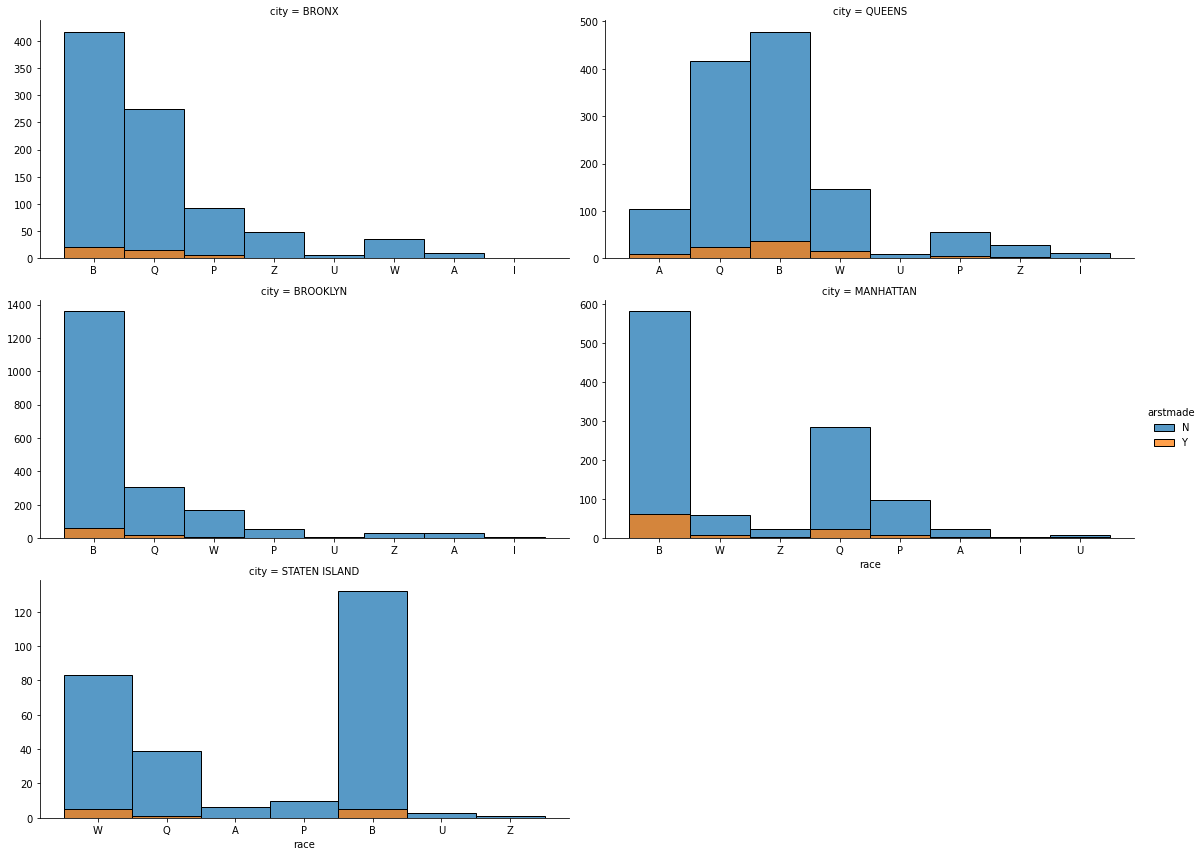

In [3]:
arrestGrid = sns.FacetGrid(df, col='city', hue='arstmade', col_wrap=2, sharex=False, sharey=False, height=4, aspect=2)
arrestGrid.map(sns.histplot, 'race').add_legend()


Text(0.5, 1.0, 'arstmade = Y')

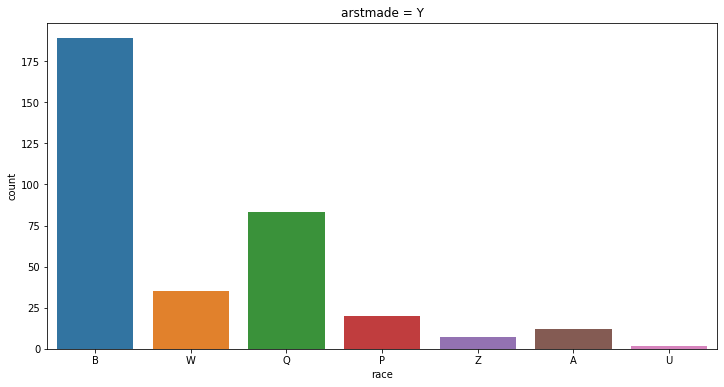

In [4]:
# Vemos también la distribución total de razas para arstmade = Y
sns.countplot(x='race', data=df[df['arstmade'] == 'Y'])
plt.title('arstmade = Y')

Vemos claramente que en general la mayor cantidad de arrestos se hace a personas de raza negra, seguido por blanco-hispánicos, blancos y negro-hispánicos. Este desbalance de clases sesgará el aprendizaje del modelo y pocas veces predecirá un arresto a las razas con menos observaciones.

Continuamos con el género

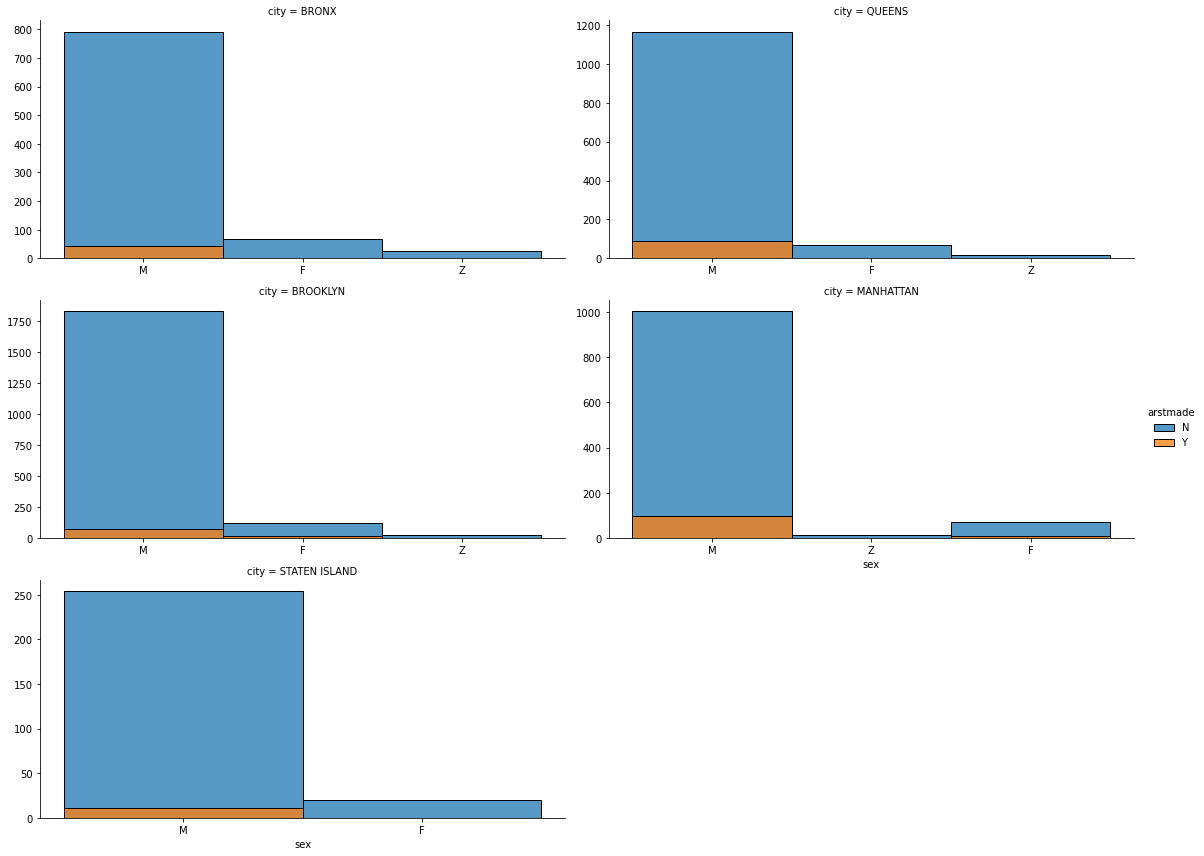

In [5]:
arrestGrid2 = sns.FacetGrid(df, col='city', hue='arstmade', col_wrap=2, sharex=False, sharey=False, height=4, aspect=2)
arrestGrid2.map(sns.histplot, 'sex').add_legend()

Text(0.5, 1.0, 'arstmade = Y')

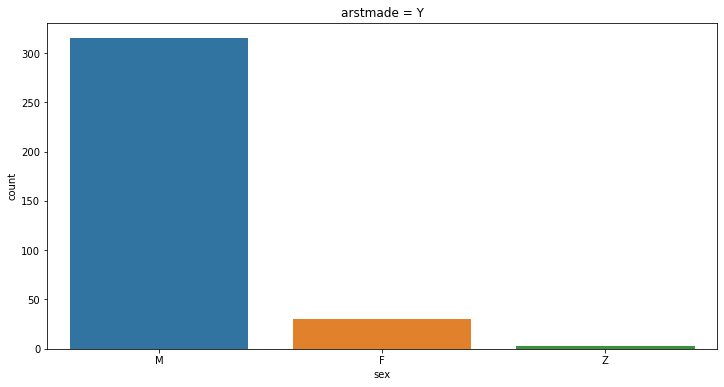

In [6]:
# Vemos también la distribución total de generos para arstmade = Y
sns.countplot(x='sex', data=df[df['arstmade'] == 'Y'])
plt.title('arstmade = Y')

Vemos que la mayoría de los arrestos son a hombres y muy pocos para mujeres, siendo la mayoría de los arrestos mujeres en brooklyn.

Vemos también que la cantidad de observaciones para cada barrio varía demasiado, esto claramente por temas demográficos, siendo brooklyn el con mayor representación y staten island el con menor.

### Feature Engineering
A continuación haremos el análisis de datos perdidos

<AxesSubplot:>

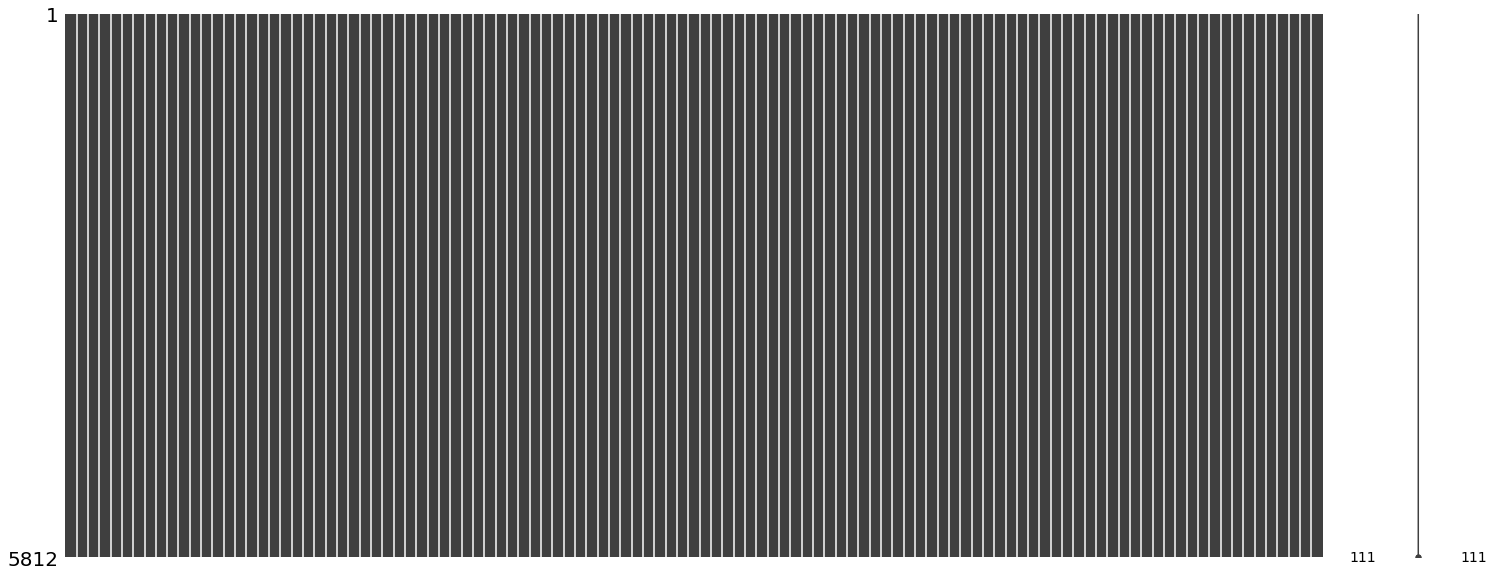

In [7]:
msno.matrix(df)

Al parecer no hay ninguno lo que es bastante bueno. Continuaremos con la refactorización de valores

In [4]:
# importamos el hash de labels de nuestro archivo helper creado en base al archivo xlsx
import refactoringParams as rfParams2

Este archivo nos entregará listas para cómo utilizar cada columna del dataframe. Además de reformatear algunas columnas, se eliminarán otras que se detallan a continuación:

- [`addrnum`, `arstoffn`, `addrtyp`, `aptnum`, `crossst`, `arstoffn`, `premname`, `stinter`, `stname`, `xcoord` y `ycoord`, `year`, `beat`, `post`]: Presentan información en texto respecto a lugar de parada o del domicilio del precinto. El cual se puede correlacionar facilmente con otros atributos como `city` y `sector`.
- [`comppct`, `compyear`, `dettypcm`, `state`, `dob`, `premtype`, `rescode`, `zip`, `ser_num`, `linecm`, `othfeatr`]: Variables que después de un análisis se ve no aportan información considerable.

Aparte agregaremos ciertas columnas usando otras con el objetivo de minimizar la dimensionalidad o en otros casos conseguir mejores datos 
- `imc`: se calculará en base a `weight`, `ht_feet` y `ht_inch`
- `day`: el día de la semana para la parada
- `month`: el mes de la parada
- `daytime`: El momento del día según la hora, pueden ser:
  - `early_morning`: entre 00am y 06am
  - `morning`: entre 06am y 12pm
  - `afternoon`: entre 12pm y 6pm
  - `night`: entre 6pm y 00am
Estos 3 últimos calculados según `datestop` y `timestop`

In [5]:
# Funcion que refactoriza el dataframe de la base de datos
def refactorDataframe(df):
    # Quitamos los atributos que no nos interesan
    refactoredDf = df.drop(columns=rfParams2.removeLabels)

    # Se inicializan las series para los atributos a agregar
    imcSerie = pd.Series(dtype='float64')
    dateSerie = pd.Series(dtype='object')
    monthSerie = pd.Series(dtype='object')
    daytimeSerie = pd.Series(dtype='object')
    # Se itera sobre las filas del df original
    for i, row in df.iterrows():
        # Se agrega el imc en kg/m2 (considerando weight en lb y height en ft)
        imcSerie.at[i] = (row['weight']*.453)/((row['ht_feet']*12*.0254) + (row['ht_inch']*.0254))**2
        # Se parsea la fecha y hora del parametro en un string ISO
        strdate = str(row['datestop'])
        strTime = str(row['timestop'])
        year = strdate[-4:]
        date = strdate[-6:-4]
        month = strdate[0:-6]
        hour= strTime[-4:-2]
        minute = strTime[-2:]
        if hour == '' or int(hour) >= 24:
            hour = '00'
        if len(hour) == 1:
            hour = '0' + hour
        if len(minute) == 1:
            minute = '0' + minute
        if len(month) == 1:
            month = '0' + month
        # Se consigue la instancia de fecha considerando la hora en NYC
        isoString = f'{year}-{month}-{date}T{hour}:{minute}:00-04:00'
        dateStop = datetime.datetime.fromisoformat(isoString)
        # Se agrega la info a la serie con información de dia y mes
        dateSerie.at[i] = dateStop.strftime('%a')
        monthSerie.at[i] = dateStop.strftime('%b')
        # Se agrega el valor del daytime
        if int(hour) >= 6 and int(hour) <= 11:
            daytimeSerie.at[i] = 'morning'
        elif int(hour) >= 12 and int(hour) <= 17:
            daytimeSerie.at[i] = 'afternoon'
        elif int(hour) >= 18 and int(hour) <= 23:
            daytimeSerie.at[i] = 'night'
        else:
            daytimeSerie.at[i] = 'early_morning'
    # Se agrega la serie al dataframe
    refactoredDf = pd.concat([
        refactoredDf,
        pd.get_dummies(dateSerie, prefix='day'),
        pd.get_dummies(monthSerie, prefix='month'),
        pd.get_dummies(daytimeSerie, prefix='daytime')
    ], axis=1)
    refactoredDf['imc'] = imcSerie

    # Se hace one-hot encoding de los atributos categoricos multiclase
    for col in rfParams2.multiClassLabels:
        refactoredDf = pd.concat([refactoredDf, pd.get_dummies(refactoredDf[col], prefix=col)], axis=1)
        refactoredDf = refactoredDf.drop(columns=col)
    # Se hace one-hot encoding de los atributos categoricos binarios
    for col in rfParams2.binaryLabels:
        refactoredDf = pd.concat([refactoredDf, pd.get_dummies(refactoredDf[col], prefix=col, drop_first=True)], axis=1)
        refactoredDf = refactoredDf.drop(columns=col)
    # Nos aseguramos de convertir las variables numéricas a float
    for col in rfParams2.numericLabels:
        refactoredDf[col] = refactoredDf[col].astype('float64')
    return refactoredDf
refactoredDf = refactorDataframe(df)

<AxesSubplot:>

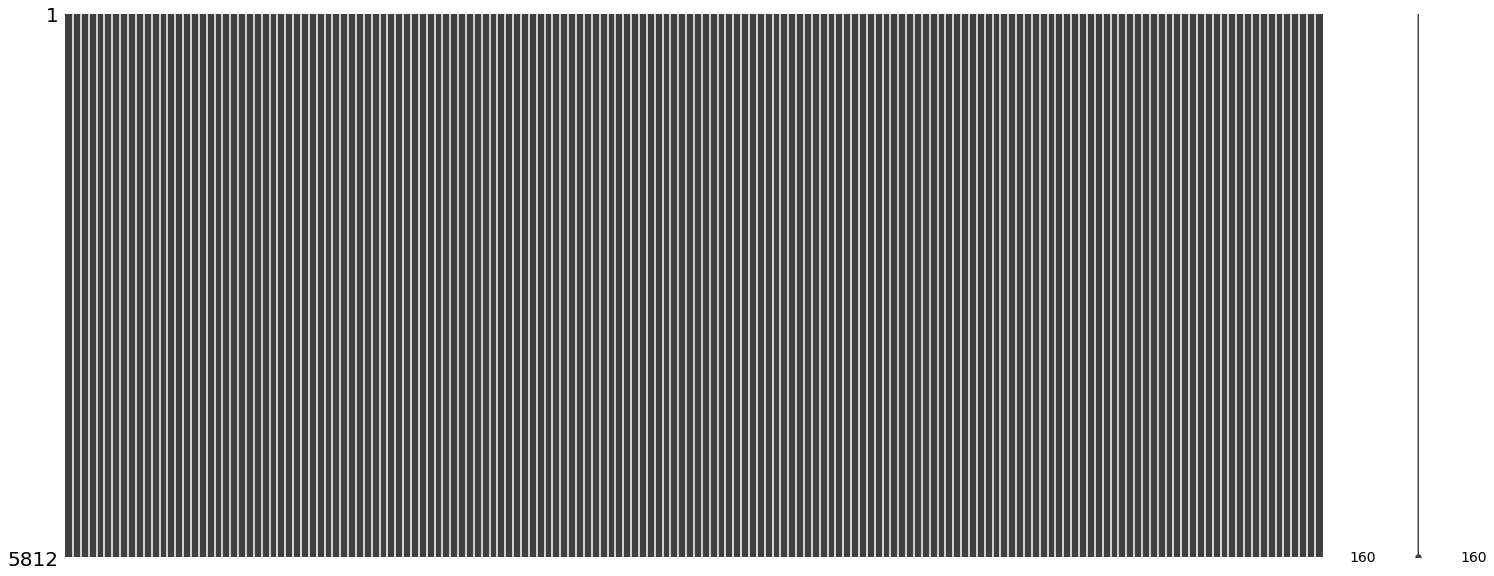

In [10]:
msno.matrix(refactoredDf)

Finalmente haremos a una mezcla de gaussianas usando atributos multiclases con espacios muestrales muy grandes como:
- `pct` y `addrpct`: códigos del precinto de la detención y de procesamiento de la misma.
- `detailcm`, `sumooffen` y `crimsusp`: Información respecto al crimen sospechado y cometido en cada detención.
- `repcmd` y `revcmd`: información del cargo del que ordenó y revisó la detención.
Luego agregaremos la probabilidad de predicción de cada clase y la agregaremos al espacio de atributos final.

In [6]:
# Intentaremos hacer un modelo Mezcla de Gaussianas con una mezcla de las variables categoricas para sospecha de crímenes
n_components = np.linspace(1, 15, 15, dtype='int')
# Separamos las columnas para hacer la mezcla de gaussianas
X = pd.concat([
    df.loc[:, ['repcmd', 'revcmd']],
    pd.get_dummies(df.loc[:, ['pct', 'addrpct', 'detailcm']]),
    pd.get_dummies(df['sumoffen']),
    pd.get_dummies(df['crimsusp']),
], axis=1)
# Escalamos nuestro espacio de atributos con StandardScaler
gaussianScaler = StandardScaler()
X = gaussianScaler.fit_transform(X)

Traemos una función de la lectura para poder poder elegir la mejor mezcla según AIC y BIC.

In [7]:
# Hacemos la busqueda de grilla manual con los mismos parámetros pero ahora usando el criterio AIC y BIC para estimar el número de clusters
def gmm_information_criteria_report(X_mat, k = np.arange(1, 20), covar_type = ['full', 'tied', 'diag', 'spherical'], random_seed=11238, out="Graph"):
    # Dataframe transposing closure type funct
    def handle_df(list_of_list, covar_type):
        tmp_df = pd.DataFrame(list_of_list).T
        tmp_df.columns = covar_type
        tmp_df['n_components'] = tmp_df.index
        return tmp_df
    tmp_global_aic, tmp_global_bic = [], []
    for i in covar_type:
        tmp_iter_aic, tmp_iter_bic = [], []
        for j in k:
            tmp_model = GaussianMixture(j, covariance_type=i,
                                        random_state = random_seed).fit(X_mat)
            tmp_iter_aic.append(tmp_model.aic(X_mat))
            tmp_iter_bic.append(tmp_model.bic(X_mat))
        tmp_global_aic.append(tmp_iter_aic)
        tmp_global_bic.append(tmp_iter_bic)

    covar_type = covar_type
    tmp_get_aic = handle_df(tmp_global_aic, covar_type)
    tmp_get_bic = handle_df(tmp_global_bic, covar_type)
    tmp_get_aic_max = pd.melt(tmp_get_aic, id_vars=['n_components'],
                              value_vars = covar_type).sort_values(by='value')
    tmp_get_bic_max = pd.melt(tmp_get_bic, id_vars=['n_components'],
                              value_vars = covar_type).sort_values(by='value')
    tmp_top_aic = tmp_get_aic_max.head(3)
    tmp_top_bic = tmp_get_bic_max.head(3)

    if out == "Graph":
        plt.subplot(2, 1, 1)
        for colname, index in tmp_get_aic.drop(columns='n_components').iteritems():
            plt.plot(index, label=colname)
        plt.scatter(tmp_top_aic['n_components'],
                    tmp_top_aic['value'], edgecolors='slategrey',
                    facecolor='none', lw=2, label="Best hyperparams")
        plt.title('Akaike Information Criteria')
        plt.xticks(k - 1, k)
        plt.xlabel('Number of clusters estimated')
        plt.ylabel('AIC')
        plt.legend(loc='center left', bbox_to_anchor=(1, .5))

        plt.subplot(2, 1, 2)
        for colname, index, in tmp_get_bic.drop(columns='n_components').iteritems():
            plt.plot(index, label=colname)
        plt.scatter(tmp_top_bic['n_components'],
                    tmp_top_bic['value'], edgecolors='slategrey',
                    facecolor='none', lw=2, label="Best hyperparams")
        plt.title('Bayesian Information Criteria')
        plt.xticks(k - 1, k)
        plt.xlabel('Number of clusters estimated')
        plt.ylabel('BIC')
        plt.legend(loc='center left', bbox_to_anchor=(1, .5))

    elif out != "Graph":
        return tmp_get_aic_max, tmp_get_bic_max


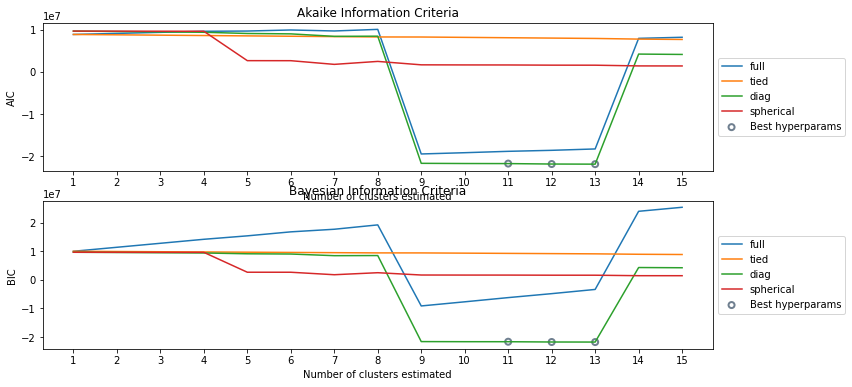

In [13]:
gmm_information_criteria_report(X, k=n_components, random_seed=19137)

Como queremos minimizar la cantidad de atributos, elegiremos `n_components=9` pues no presenta mucha diferencia con respecto a los otros atributos.

In [8]:
bestGMM = GaussianMixture(n_components=9, covariance_type='diag', random_state=19137).fit(X)

In [9]:
# Guardamos el dataframe con las probabilidades de cada cluster
gmmProbaDf = pd.DataFrame(bestGMM.predict_proba(X), columns=['GMM_' + str(x) for x in range(9)])

## Hito 2

Primero haremos la separación de conjuntos para entrenamiento y prueba

In [10]:
# Separamos nuestra muestra para el entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(refactoredDf.drop(columns=['arstmade_Y']), refactoredDf['arstmade_Y'], test_size=0.33, random_state=19137)
# Igual pero agregando las probabilidades de nuestro modelo generativo
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(pd.concat([refactoredDf.drop(columns=['arstmade_Y']), gmmProbaDf], axis=1), refactoredDf['arstmade_Y'], test_size=0.33, random_state=19137)
# Escalamos nuestro espacio de atributos con StandardScaler
baseScaler = StandardScaler()
gmmScaler = StandardScaler()
X_train = baseScaler.fit_transform(X_train)
X_test = baseScaler.transform(X_test)
X_GMM_train = gmmScaler.fit_transform(X_GMM_train)
X_GMM_test = gmmScaler.transform(X_GMM_test)

Luego comenzamos haciendo los modelo de predicción de arresto con los tres métodos antes mencionados:

1. `Random Forest`:
   - `max_depth`: 10 valores entre `1` y `30`
   - `n_estimators`: 5 valores entre `50` y `500`
   - `max_features`: `['auto', 'sqrt', 'log2']`
   - `oob_score`: `[True]`

In [30]:
# Implementamos el modelo con Random Forest
max_depth = np.linspace(1, 30, 10, dtype=int)
n_estimators = np.linspace(50, 500, 5, dtype=int)
max_features = ['auto', 'sqrt', 'log2']


In [31]:
# Instanciamos el modelo y lo entrenamos
rfModel = GridSearchCV(RandomForestClassifier(random_state=19137, oob_score=True), {'max_depth': max_depth, 'n_estimators': n_estimators, 'max_features': max_features}, cv=5, scoring='roc_auc')
rfModel.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=19137),
             param_grid={'max_depth': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 50, 162, 275, 387, 500])},
             scoring='roc_auc')

In [32]:
# Notificamos los mejores hiperámetros y las métricas
print('Best parameters: ', rfModel.best_params_)
print(classification_report(y_test, rfModel.predict(X_test)))

Best parameters:  {'max_depth': 17, 'max_features': 'log2', 'n_estimators': 387}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1801
           1       0.87      0.47      0.61       117

    accuracy                           0.96      1918
   macro avg       0.92      0.73      0.80      1918
weighted avg       0.96      0.96      0.96      1918



Vemos que el modelo pudo identificar correctamente el 100% de cuando no hay arresto, sin embargo sólo identificó correctamente el 47% de los casos en que si hubo arresto. Por otro lado, se presenta una buena precisión para ambas clases, siendo de un 97% para '0' y 87% para '1' 

In [33]:
# Instanciamos y entrenamos el modelo con las columnas de GMM
rfGmmModel = GridSearchCV(RandomForestClassifier(random_state=19137, oob_score=True), {'max_depth': max_depth, 'n_estimators': n_estimators, 'max_features': max_features}, cv=5, scoring='roc_auc')
rfGmmModel.fit(X_GMM_train, y_GMM_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=19137),
             param_grid={'max_depth': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 50, 162, 275, 387, 500])},
             scoring='roc_auc')

In [34]:
# Evaluamos el modelo y los mejores hiperparámetros
print('Best parameters: ', rfGmmModel.best_params_)
print(classification_report(y_GMM_test, rfGmmModel.predict(X_GMM_test)))

Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 387}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1801
           1       0.87      0.52      0.65       117

    accuracy                           0.97      1918
   macro avg       0.92      0.76      0.82      1918
weighted avg       0.96      0.97      0.96      1918



Vemos que al agregar las probabilidades de la GMM al espacio de atributos se mejora en un 5% el recall de la clase '1', es decir, se identificó correctamente un 5% mas de la muestra que con el modelo anterior.

2. `GaussianNB`
   - `var_smoothing`: 20 muestras entre `1e-9` y `2`
   - `priors`: 6 combinaciones de probabilidades `.2` y `.8`

In [32]:
# Definimos los hiperparámetros para el modelo de GaussianNB
nb_var_smoothing = np.linspace(1e-9, 2, 20)
nb_priors = list(map(lambda x: [x, 1 - x], np.linspace(.2, .8, 6)))

In [31]:
# Implementamos el modelo de Bayes Ingenuo
nbModel = GridSearchCV(GaussianNB(), {'var_smoothing': nb_var_smoothing, 'priors': nb_priors}, cv=15, scoring='roc_auc')
nbModel.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jo

GridSearchCV(cv=15, estimator=GaussianNB(),
             param_grid={'priors': [[1e-10, 0.9999999999],
                                    [0.02564102573846154, 0.9743589742615385],
                                    [0.05128205137692308, 0.9487179486230769],
                                    [0.0769230770153846, 0.9230769229846154],
                                    [0.10256410265384615, 0.8974358973461538],
                                    [0.1282051282923077, 0.8717948717076923],
                                    [0.15384615393076922, 0.8461538460692308],
                                    [0.17948717956923077,...
                                    [0.7435897436153847, 0.25641025638461534], ...],
                         'var_smoothing': array([1.00000000e-09, 1.05263159e-01, 2.10526317e-01, 3.15789475e-01,
       4.21052632e-01, 5.26315790e-01, 6.31578948e-01, 7.36842106e-01,
       8.42105264e-01, 9.47368422e-01, 1.05263158e+00, 1.15789474e+00,
       1.26315790e+00, 1

In [33]:
# Evaluamos el modelo y los mejores hiperparámetros
print('Best parameters: ', nbModel.best_params_)
print(classification_report(y_test, nbModel.predict(X_test)))

Best parameters:  {'priors': [0.02564102573846154, 0.9743589742615385], 'var_smoothing': 2.0}
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1801
           1       0.44      0.68      0.53       117

    accuracy                           0.93      1918
   macro avg       0.71      0.81      0.75      1918
weighted avg       0.95      0.93      0.93      1918



Vemos que a diferencia de RF, este logra un mejor recall para la clase '1', pero pierde mucha precisión en la misma. La clase 0 se mantiene estable respecto a la anterior, con una diferencia de 4% de su recall.

In [34]:
# Implementamos el modelo de Bayes Ingenuo con las columnas extras de GMM
nbGmmModel = GridSearchCV(GaussianNB(), {'var_smoothing': nb_var_smoothing, 'priors': nb_priors}, cv=15, scoring='roc_auc')
nbGmmModel.fit(X_GMM_train, y_GMM_train)

D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:454: RuntimeWarning: divide by zero encountered in log
  jo

GridSearchCV(cv=15, estimator=GaussianNB(),
             param_grid={'priors': [[1e-10, 0.9999999999],
                                    [0.11111111119999999, 0.8888888888],
                                    [0.2222222223, 0.7777777777],
                                    [0.3333333334, 0.6666666666000001],
                                    [0.4444444445, 0.5555555555],
                                    [0.5555555556, 0.44444444439999997],
                                    [0.6666666667, 0.33333333330000003],
                                    [0.7777777777999999, 0.2222222222000001],
                                    [0.8888888889, 0.11111111110000...
                                    [1.0, 0.0]],
                         'var_smoothing': array([1.00000000e-09, 1.05263159e-01, 2.10526317e-01, 3.15789475e-01,
       4.21052632e-01, 5.26315790e-01, 6.31578948e-01, 7.36842106e-01,
       8.42105264e-01, 9.47368422e-01, 1.05263158e+00, 1.15789474e+00,
       1.26315790e+00

In [35]:
# Evaluamos el modelo y los mejores hiperparámetros
print('Best parameters: ', nbGmmModel.best_params_)
print(classification_report(y_GMM_test, nbGmmModel.predict(X_GMM_test)))

Best parameters:  {'priors': [0.11111111119999999, 0.8888888888], 'var_smoothing': 2.0}
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1801
           1       0.45      0.66      0.53       117

    accuracy                           0.93      1918
   macro avg       0.71      0.80      0.75      1918
weighted avg       0.94      0.93      0.94      1918



A groso modo, el agregar las columnas de la mezcla de gaussianas no afecta el desempeño del modelo pues no cambia el *f1-score* ni el *accuracy*, sólo hay un reajuste minúsculo entre los recall y las precisiones de estas clases.

3. `Decision Tree con GradientBoost`:
   - `learning_rate`: 5 valores entre `.01` y `.05`
   - `n_estimators`: 5 valores entre `50` y `500`
   - `subsample`: 10 valores entre `.1` y `1`
   - `max_depth`: 10 valores entre `1` y `30`

In [36]:
# Definimos los hiperparámetros para el modelo de GradientBoost
learning_rate = np.linspace(0.01, 0.5, 5)
n_estimators = np.linspace(50, 500, 5, dtype=int)
max_depth = np.linspace(1, 30, 10, dtype=int)
subsample = np.linspace(0.1, 1, 10)

In [38]:
# Definimos la busqueda de grilla
gbModel = GridSearchCV(GradientBoostingClassifier(random_state=19137), {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth, 'subsample': subsample}, cv=5, scoring='roc_auc', n_jobs=-1)
gbModel.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=19137),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ]),
                         'max_depth': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30]),
                         'n_estimators': array([ 50, 162, 275, 387, 500]),
                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='roc_auc')

In [39]:
# Vemos las métricas del modelo
print('Best parameters: ', gbModel.best_params_)
print(classification_report(y_test, gbModel.predict(X_test)))

Best parameters:  {'learning_rate': 0.01, 'max_depth': 26, 'n_estimators': 500, 'subsample': 0.5}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1801
           1       0.81      0.67      0.73       117

    accuracy                           0.97      1918
   macro avg       0.90      0.83      0.86      1918
weighted avg       0.97      0.97      0.97      1918



In [40]:
# Definimos la busqueda de grilla para el modelo con las columnas de GMM
gbGmmModel = GridSearchCV(GradientBoostingClassifier(random_state=19137), {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth, 'subsample': subsample}, cv=5, scoring='roc_auc', n_jobs=-1)
gbGmmModel.fit(X_GMM_train, y_GMM_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=19137),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ]),
                         'max_depth': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30]),
                         'n_estimators': array([ 50, 162, 275, 387, 500]),
                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='roc_auc')

In [41]:
print('Best parameters: ', gbGmmModel.best_params_)
print(classification_report(y_GMM_test, gbGmmModel.predict(X_GMM_test)))

Best parameters:  {'learning_rate': 0.1325, 'max_depth': 26, 'n_estimators': 500, 'subsample': 0.9}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1801
           1       0.85      0.50      0.63       117

    accuracy                           0.96      1918
   macro avg       0.91      0.75      0.80      1918
weighted avg       0.96      0.96      0.96      1918

